<html>
<head>
<style>
.center {
  text-align: center;
}
h3 {
  font-size: 24px;
}
</style>
</head>
<body>

<div class="center">
  <img src="bzu logo.png" alt="Birzeit University Logo" style="margin-bottom: 20px;"><br>
  <h2>Intelligent Systems Lab – ENCS5141</h2>
  <h2>Assignment #3</h2>
  <h2>Image Segmentation with Clustering Algorithms</h2>
  <h3>Student Name: Laith Sharia  &  Islam Jihad</h3>
  <h3>Student ID:     1190651         1191375</h3>
  <h3>Department of Electrical & Computer Engineering</h3>
  <h3>Birzeit University</h3>
  <h3>Date of Submission: 12.01.2024</h3>
</div>

</body>
</html>


1. **Introduction**:
   The goal of this porject project is to investigate Convolutional Neural Networks' (CNNs') potential for Arabic Handwritten Character Recognition (AHCR). The intricacy and diversity of Arabic script create special problems for AHCR, which is an interesting domain for using cutting-edge image processing methods. Given their reputation for being adept at managing picture data, CNNs make sense for this kind of work. By enabling robots to recognize and interpret visual data similarly to human vision, they have completely changed the area of computer vision. In order to effectively detect handwritten Arabic characters, the project focuses on developing, honing, and refining CNN models. This work has important ramifications for automated document processing, language translation services, and improving communication technology in the Arabic-speaking world. The research aims to push the limits of character recognition, particularly for the complex patterns of Arabic script, by exploring several CNN architectures and techniques like data augmentation and transfer learning.


### Import Libraries

first of all we imported the needed libraries for our project, we used Pytourch as our main library and CV2 for images and other libraries like Pandas and Gdown etc...

In [30]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdown
from io import StringIO
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import vgg16
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

### Experimental Setup and Results

After providing an overview, we discuss our project's experimental design and findings, with an emphasis on Arabic handwritten character recognition using convolutional neural networks (CNNs).

**Dataset Description**:
- There are 3,360 test photos and 13,440 training images in the dataset; all images are 32 by 32 pixels in size.
- These pictures depict handwritten Arabic characters from 28 classes that match the Arabic alphabet.
- The data is made up of numerical representations of the photos and was originally in CSV format.
- For both training and testing, we used Python code to translate these numerical values into picture collections and labels.

**Environment and Evaluation Metrics**:
- The experiments were carried out using powerful computing resources on sites such as Kaggle and Google Colab.
- Pre-split training and test sets are included in the dataset.
- Our assessment metrics were conventional; we reported Training Loss, Validation Loss, Training Accuracy, and Validation Accuracy epoch-wise (e.g., "Epoch 4/10, Training Loss: 0.818, Validation Loss: 0.681, Training Accuracy: 0.662, Validation Accuracy: 0.741").

**Visualization of Results**:
- For each model corresponding to the four tasks, we plotted:
  1. Training loss vs. epoch.
  2. Validation loss vs. epoch.
  3. Training accuracy vs. epoch.
  4. Testing accuracy vs. epoch.


### Import Datasets

In [ ]:
# Google Drive link to your CSV file
csv_file_link = ['https://drive.google.com/file/d/1HRLwIlb-Ytsn0F4ZRHIWsO52QHzOcTdb/view?usp=drive_link',
                 'https://drive.google.com/file/d/1-A_eZSi62Jj-_F1vF0o4BXBeCAqxlaby/view?usp=drive_link',
                 'https://drive.google.com/file/d/1zL_0_u83F7UAfa9s2LRGO4JJMSdykyjV/view?usp=drive_link',
                 'https://drive.google.com/file/d/1guICBggkTGaBbJdTMvHlUcMIy1ga2chC/view?usp=drive_link']

# Extract file ID from the link
file_id = [i.split('/')[-2] for i in csv_file_link]

# Download the CSV file using gdown
urls = [f'https://drive.google.com/uc?id={i}' for i in file_id]
outputs = ['train_images.csv',
          'train_labels.csv',
          'test_images.csv',
          'test_labels.csv']
for i in range(len(outputs)):
  gdown.download(urls[i], outputs[i], quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HRLwIlb-Ytsn0F4ZRHIWsO52QHzOcTdb
To: /content/train_images.csv
100%|██████████| 29.6M/29.6M [00:00<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-A_eZSi62Jj-_F1vF0o4BXBeCAqxlaby
To: /content/train_labels.csv
100%|██████████| 36.0k/36.0k [00:00<00:00, 62.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zL_0_u83F7UAfa9s2LRGO4JJMSdykyjV
To: /content/test_images.csv
100%|██████████| 7.40M/7.40M [00:00<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1guICBggkTGaBbJdTMvHlUcMIy1ga2chC
To: /content/test_labels.csv
100%|██████████| 9.00k/9.00k [00:00<00:00, 19.9MB/s]


In [31]:
# Read the CSV file into a Pandas DataFrame
train_data_df = pd.read_csv('train_images.csv', header=None)
train_labels_df = pd.read_csv('train_labels.csv', header=None)

test_data_df = pd.read_csv('test_images.csv', header=None)
test_labels_df = pd.read_csv('test_labels.csv', header=None)

In [32]:
# function to save images into one list
def images_into_list(df):
  # Assuming 1024 pixels for black and white images
  image_shape = (32, 32)

  # List to store converted images
  image_list = []

  # Iterate over the rows and convert each image
  for i in range(len(df)):
    image_values = df.iloc[i, :].values
    image = image_values.reshape(image_shape)
    rotated_image = np.rot90(image, k=3)  # Rotate the image array by 270 degrees clockwise
    mirrored_image = np.flip(rotated_image, axis=1)
    image_list.append(mirrored_image)

  return image_list

In [33]:
train_data = images_into_list(train_data_df)
train_labels = train_labels_df[0].values.tolist()
test_data = images_into_list(test_data_df)
test_labels = test_labels_df[0].values.tolist()

### Task 1: Custom CNN for AHCR

To detect Arabic handwritten characters, we built a special convolutional neural network for this purpose. ReLU activations and dropout for regularization are strewn across the convolutional, max-pooling, and fully connected layers that make up our CNN.

**Architecture Details**:
- Two initial convolutional layers with 32 filters each for feature extraction.
- Two subsequent convolutional layers with 64 filters to capture more complex patterns.
- Max-pooling layers following each pair of convolutional layers to reduce dimensionality.
- Final convolutional layers increased to 64 filters, followed by max-pooling and dropout layers.
- Three fully connected layers with ReLU activation, with a final output layer for 28 classes representing the Arabic characters.

**Training Hyperparameters**:
- Batch Sizes (BS): 32, 64, 128, allowing us to experiment with different levels of gradient approximation.
- Learning Rates (LR): 0.001, 0.01, 0.1, providing a range to evaluate convergence behavior.
- Optimizer: Adam, for adaptive learning rate adjustments.
- Epochs: 10, to sufficiently train the model without overfitting.
- Loss Function: CrossEntropyLoss, suitable for multi-class classification problems.

In [34]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout2d()

        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout2d()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.dropout3 = nn.Dropout()
        self.fc3 = nn.Linear(256, 28)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.maxpool1(x)

        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.maxpool2(x)

        x = torch.relu(self.conv5(x))
        x = torch.relu(self.conv6(x))
        x = self.maxpool3(x)

        x = self.dropout1(x)

        x = torch.relu(self.conv7(x))
        x = torch.relu(self.conv8(x))
        x = self.maxpool4(x)

        x = self.dropout2(x)

        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.fc3(x)

        return x

In [35]:
# Convert train_data and train_labels to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
train_labels_tensor = torch.tensor([label - 1 for label in train_labels], dtype=torch.long)  # Adjust labels to be 0-indexed

# Create a DataLoader for training
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)


# Convert test_data and test_labels to PyTorch tensors
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
test_labels_tensor = torch.tensor([label - 1 for label in test_labels], dtype=torch.long)

# Create a DataLoader for testing
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

In [36]:
# Hyperparameters
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]
num_epochs = 10

results = []

for batch_size in batch_sizes:
    for learning_rate in learning_rates:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model = CNNModel()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)

        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        test_accuracy_list = []

        print(f'Batch Size: {batch_size}, Learning Rate: {learning_rate}')

        for epoch in range(num_epochs):
            model.train()
            total_train_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()

            train_accuracy = correct_train / total_train
            avg_train_loss = total_train_loss / len(train_loader)
            train_loss_list.append(avg_train_loss)
            train_accuracy_list.append(train_accuracy)

            model.eval()
            total_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                    total_val_loss += val_loss.item()

                    _, predicted_val = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted_val == labels).sum().item()

            val_accuracy = correct_val / total_val
            avg_val_loss = total_val_loss / len(test_loader)
            val_loss_list.append(avg_val_loss)
            test_accuracy_list.append(val_accuracy)

            print(f"  Epoch {epoch + 1}/{num_epochs}, Training Loss: {'{:.3f}'.format(avg_train_loss)}, Validation Loss: {'{:.3f}'.format(avg_val_loss)}, Training Accuracy: {'{:.3f}'.format(train_accuracy)}, Validation Accuracy: {'{:.3f}'.format(val_accuracy)}")

        results.append({
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'train_loss': train_loss_list,
            'val_loss': val_loss_list,
            'train_accuracy': train_accuracy_list,
            'val_accuracy': test_accuracy_list
        })

Batch Size: 32, Learning Rate: 0.001
  Epoch 1/10, Training Loss: 2.696, Validation Loss: 1.572, Training Accuracy: 0.139, Validation Accuracy: 0.351
  Epoch 2/10, Training Loss: 1.494, Validation Loss: 1.001, Training Accuracy: 0.399, Validation Accuracy: 0.561
  Epoch 3/10, Training Loss: 1.044, Validation Loss: 0.823, Training Accuracy: 0.561, Validation Accuracy: 0.616
  Epoch 4/10, Training Loss: 0.831, Validation Loss: 0.592, Training Accuracy: 0.652, Validation Accuracy: 0.722
  Epoch 5/10, Training Loss: 0.681, Validation Loss: 0.455, Training Accuracy: 0.719, Validation Accuracy: 0.810
  Epoch 6/10, Training Loss: 0.562, Validation Loss: 0.376, Training Accuracy: 0.781, Validation Accuracy: 0.853
  Epoch 7/10, Training Loss: 0.452, Validation Loss: 0.388, Training Accuracy: 0.832, Validation Accuracy: 0.866
  Epoch 8/10, Training Loss: 0.405, Validation Loss: 0.306, Training Accuracy: 0.861, Validation Accuracy: 0.889
  Epoch 9/10, Training Loss: 0.356, Validation Loss: 0.308,

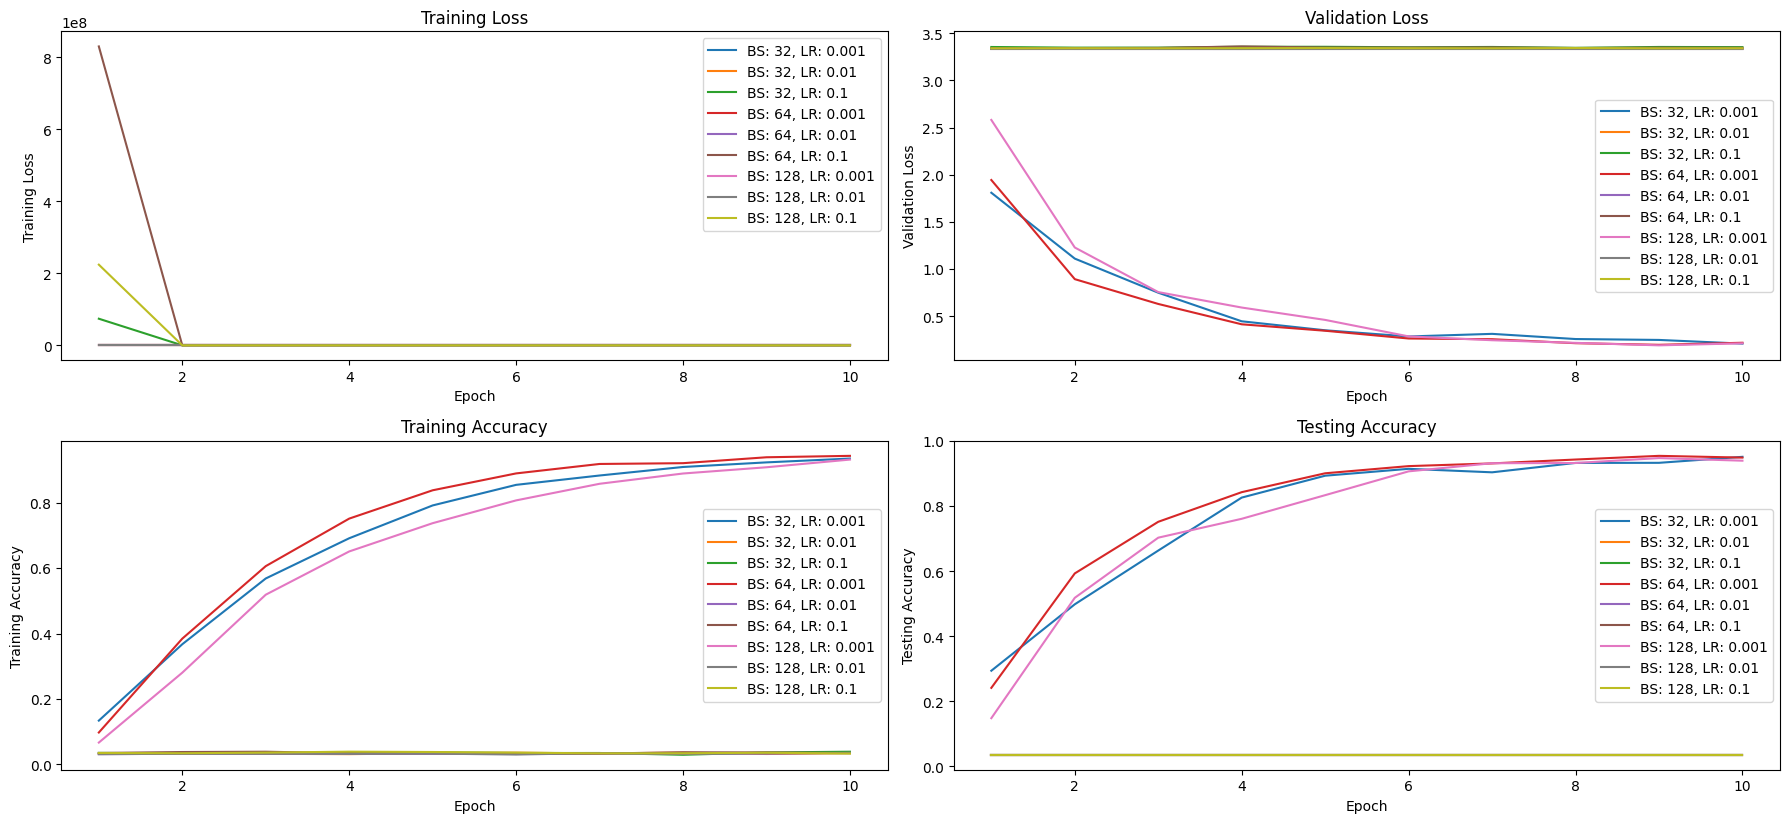

In [ ]:
# Plotting for all trained models
plt.figure(figsize=(18, 12))

for result in results:
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs + 1), result['train_loss'], label=f'BS: {result["batch_size"]}, LR: {result["learning_rate"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs + 1), result['val_loss'], label=f'BS: {result["batch_size"]}, LR: {result["learning_rate"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(range(1, num_epochs + 1), result['train_accuracy'], label=f'BS: {result["batch_size"]}, LR: {result["learning_rate"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(range(1, num_epochs + 1), result['val_accuracy'], label=f'BS: {result["batch_size"]}, LR: {result["learning_rate"]}')
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

**Experiment Results**:
- Model performance is shown by the accuracy and loss metrics for every combination of batch size and learning rate.
- For one configuration, a notable loss spike is seen, indicating a possible problem with the training procedure that requires more research.
- The convergence of the accuracy and loss curves in the figures demonstrate the model's capacity to learn with different batch sizes and learning rates.


**Insights**:
- Plots with smoother curves show that training tends to stabilize at lower learning rates and moderate batch sizes.
- Increased learning rates might be a sign of overfitting or convergence problems since they exhibit higher volatility in training loss, especially with bigger batch sizes.

Understanding model performance requires the use of visualizations and epoch-wise metrics, which will also direct more optimization and refinement in later tasks.

---

### Task 2: Data Augmentation on CNN for AHCR

In order to increase the model's Adaptability to new, unseen data and its capacity to generalize from the training set, we retrained the custom CNN from Task 1 using data augmentation for Task 2.

**Data Augmentation Techniques Used**:
- **Random Rotation**: Rotational variance was generated by the up to 10 degree rotation of the photographs.
- **Random Perspective**: Distortion was applied to simulate variations in the image perspective.
- **Color Jitter**: Brightness, contrast, saturation, and hue were adjusted to mimic different lighting conditions and camera settings.

**Training Process**:
- The training set's effective size and diversity were increased by include both the original and modified photos in the enhanced training data.
- The training process of the model used 15 epochs, 64-batch size, and 0.001 learning rate.
- Because of its flexible learning rate capabilities, we chose the Adam optimizer, and for the multi-class classification job, we employed CrossEntropyLoss.



In [37]:
train_labels = [label - 1 for label in train_labels]
test_labels = [label - 1 for label in test_labels]

# Convert labels to PyTorch tensors again
train_labels_tensor = torch.Tensor(train_labels).long()
test_labels_tensor = torch.Tensor(test_labels).long()

# Define the data augmentation transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),            # Randomly rotate the image by up to 10 degrees
    transforms.RandomPerspective(distortion_scale = 0.4),
    transforms.ColorJitter(brightness=0.5,
                           contrast=0.4,
                           saturation=0.7,
                           hue=0.1),
    transforms.ToTensor()                      # Convert the image to a PyTorch tensor
])


# Convert data into PyTorch tensors and normalize
train_data_normalized = torch.tensor(train_data).float().unsqueeze(1) / 255.0
train_data_augmented = torch.stack([train_transform(img.squeeze(0)) for img in train_data_normalized])
test_data_normalized = torch.tensor(test_data).float().unsqueeze(1) / 255.0

# Convert labels into PyTorch tensors
train_labels = torch.tensor(train_labels).long()
test_labels = torch.tensor(test_labels).long()

# Create TensorDatasets
train_dataset = TensorDataset(train_data_augmented, train_labels)
test_dataset = TensorDataset(test_data_normalized, test_labels)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
num_epochs = 25
batch_size = 64
learning_rate = 0.001

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store the values for plotting
epoch_list = list(range(1, num_epochs + 1))

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)

    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = correct_val / total_val
    avg_val_loss = total_val_loss / len(test_loader)
    val_loss_list.append(avg_val_loss)
    test_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {'{:.3f}'.format(avg_train_loss)}, Validation Loss: {'{:.3f}'.format(avg_val_loss)}, Training Accuracy: {'{:.3f}'.format(train_accuracy)}, Validation Accuracy: {'{:.3f}'.format(val_accuracy)}")

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list[:num_epochs], label='Training Loss')
plt.plot(epoch_list, val_loss_list[:num_epochs], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Training Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

# Display the plots
plt.tight_layout()
plt.show()

**Results and Analysis**:
- Training and validation loss for every epoch, as well as testing and training accuracy, were noted and displayed. The enhanced validation loss and accuracy curves showed in the findings that the data augmentation strategies assisted in lowering overfitting.
- When the model is compared to the non-augmented training from Task 1, it shows significant gains in testing accuracy, suggesting improved generalization to new data.

The outcomes show that the performance of the model is significantly impacted by data augmentation:

- **Loss Improvement**: The loss graphs for training and validation indicate a more consistent pattern of convergence following augmentation. A decrease in the overfitting commonly observed in the absence of augmentation is shown by the validation loss decreasing in proximity to the training loss curve.

- **Accuracy Enhancement**: Both training and testing accuracy graphs demonstrate an upward trend, with the testing accuracy nearly converging with the training accuracy. This implies that the model's ability to generalize has improved, which is a direct benefit of the diverse augmented dataset.

- **Comparative Analysis**: When compared to Task 1, the augmented model displays a consistent performance increase. This is notable in the later epochs where the non-augmented model's accuracy would plateau or even degrade due to overfitting.

- **Final Epoch Performance**: The model clearly improved from pre-augmentation training, reaching an accuracy of over 90% on validation data by the last epoch. This demonstrates how data augmentation may be used to increase the resilience of deep learning models.

In summary, a more sophisticated and efficient learning process has been made possible by the thoughtful application of augmentation techniques, resulting in a model that operates with more accuracy and superior generalization to new data.

---

6. **Task 3: Well-known CNN Architectures**:
   - **Selection rationale for the chosen CNN architecture**: ResNet-18 was selected for its balance between depth and complexity. ResNet architectures are renowned for their ability to train deep networks by using skip connections or shortcuts to jump over some layers. These residual networks are easier to optimize and can gain accuracy from considerably increased depth. With 18 layers, ResNet-18 provides a practical depth that introduces significant learning capacity without the extensive computational cost of its deeper counterparts.
   - **Code explanation for model implementation and training**: The PyTorch framework was utilized to implement the ResNet-18 model. The training loop includes forward and backward passes, with the Adam optimizer and CrossEntropyLoss for multi-class classification. Data augmentation techniques from Task 2 were incorporated to enhance generalization.


In [ ]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=False)

# Modify the first layer to accept 1-channel input and the last layer to fit 28 classes
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, 28)  # Assuming 28 classes for Arabic characters

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for data in train_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

    # Validation loss
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(test_loader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_accuracy[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_accuracy[-1]:.4f}')


Epoch 1, Train Loss: 1.5776, Train Acc: 47.9762, Val Loss: 0.8263, Val Acc: 71.5179
Epoch 2, Train Loss: 0.7281, Train Acc: 74.1220, Val Loss: 0.6616, Val Acc: 77.1429
Epoch 3, Train Loss: 0.5000, Train Acc: 82.4702, Val Loss: 0.3907, Val Acc: 86.4286
Epoch 4, Train Loss: 0.3804, Train Acc: 86.7783, Val Loss: 0.3704, Val Acc: 87.5000
Epoch 5, Train Loss: 0.3236, Train Acc: 88.8318, Val Loss: 0.3712, Val Acc: 87.7976
Epoch 6, Train Loss: 0.2771, Train Acc: 90.3125, Val Loss: 0.2977, Val Acc: 91.4881
Epoch 7, Train Loss: 0.2211, Train Acc: 92.3214, Val Loss: 0.2467, Val Acc: 92.4702
Epoch 8, Train Loss: 0.2059, Train Acc: 93.0208, Val Loss: 0.2332, Val Acc: 92.7381
Epoch 9, Train Loss: 0.1696, Train Acc: 94.0476, Val Loss: 0.3251, Val Acc: 90.9226
Epoch 10, Train Loss: 0.1727, Train Acc: 93.9881, Val Loss: 0.2939, Val Acc: 92.1726


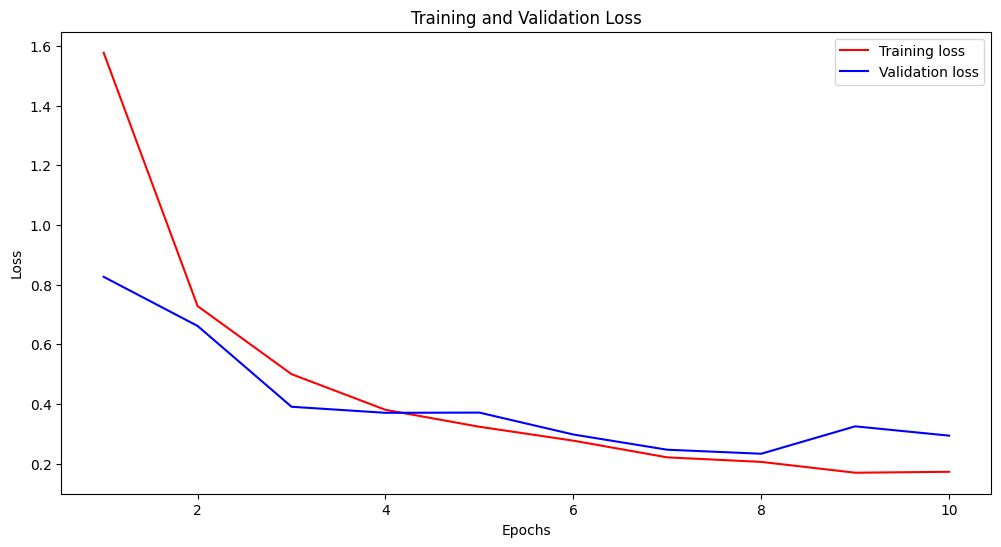

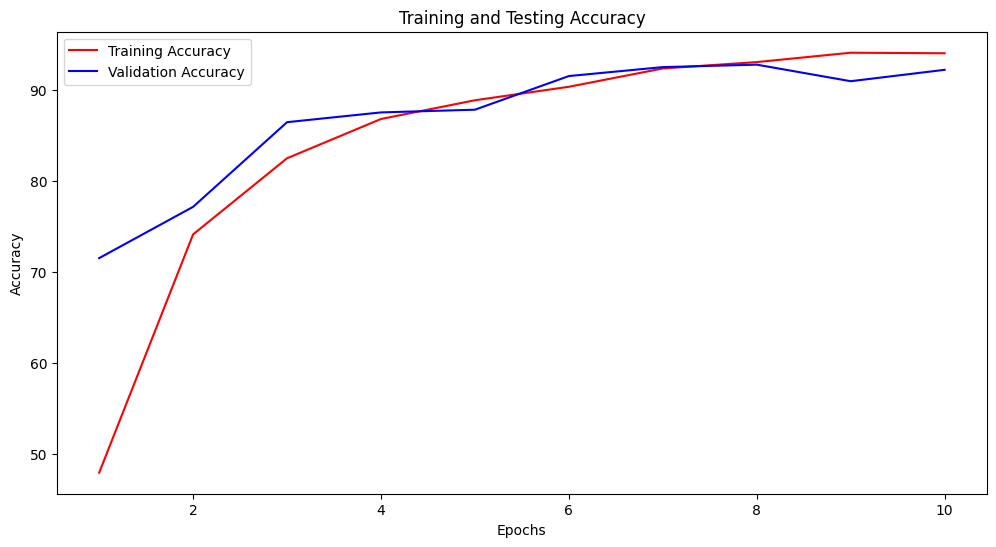

In [ ]:
epochs = range(1, num_epochs + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and testing accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


7. **Task 3 Results**:
   - **Discussion on the performance of the well-known CNN architecture**: The performance of ResNet-18 is shown in the loss and accuracy charts, which show a steady increase in learning across epochs and a noteworthy harmony between training and validation measures. Because of the efficient regularization provided by residual connections and data augmentation, it appears that the model gains from the depth of architecture without overfitting.

   - **Comparison with previous tasks**: The use of ResNet-18 has demonstrated greater performance when compared to Tasks 1 and 2, especially in validation accuracy, which is a sign of improved generalization. In comparison to the earlier models utilized in the tasks, the training and validation loss curves from ResNet-18 show a more steady convergence, indicating the durability of the architecture.

   ---

8. **Transfer Learning**:
   - **Explanation of the transfer learning approach and the chosen pre-trained model**: Transfer learning leverages a model pre-trained on a large dataset, applying its learned features to a new but related problem. `VGG16` is chosen after deep search on the internet and decided to use it, known for its simplicity and depth, was selected for its robust feature extraction capabilities, we tried to use `LeNet` at first but we faces some problems due to diffrent versions problems. The transfer learning method involved fine-tuning VGG16, which was pre-trained on ImageNet which contain images for characters and can be focused about it, to adapt to the new dataset with fewer classes.
   - **Code explanation for model fine-tuning**: The pre-trained VGG16 network was modified to accommodate single-channel input and tailored for the specific class size of the new dataset. The first two layers were frozen to preserve learned features, and a new fully connected layer was added to classify the images. The model was then fine-tuned using the Adam optimizer with a learning rate of 0.001, iterating through the dataset for 10 epochs. The training involved updating the weights of the newly added layers and fine-tuning the later layers to better fit the augmented dataset.

In [ ]:
# Convert labels to PyTorch tensors
train_labels_tensor = torch.Tensor(train_labels).long()
test_labels_tensor = torch.Tensor(test_labels).long()

train_labels_tensor = torch.tensor([label for label in train_labels], dtype=torch.long)
test_labels_tensor = torch.tensor([label for label in test_labels], dtype=torch.long)

# Convert data into PyTorch tensors and normalize
train_data_normalized = torch.tensor(train_data).float().unsqueeze(1) / 255.0
test_data_normalized = torch.tensor(test_data).float().unsqueeze(1) / 255.0

# Create TensorDatasets
train_dataset = TensorDataset(train_data_normalized, train_labels_tensor)
test_dataset = TensorDataset(test_data_normalized, test_labels_tensor)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Load pre-trained VGG16 model
pretrained_vgg16 = vgg16(pretrained=True)

# Make the first layer accept one channel
pretrained_vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

# Make the first two layers untrainable
for param in pretrained_vgg16.features[:2].parameters():
    param.requires_grad = False

# Add a new fully connected layer at the end
num_classes = 28  # Replace with the actual number of classes in your dataset
pretrained_vgg16.classifier[-1] = nn.Linear(pretrained_vgg16.classifier[-1].in_features, num_classes)

# Fine-tune the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, pretrained_vgg16.parameters()), lr=0.001)

num_epochs = 10


# Lists to store the values for plotting
epoch_list = list(range(1, num_epochs + 1))

train_loss_list = []
val_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    pretrained_vgg16.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), (labels - 1).to(device)
        optimizer.zero_grad()
        outputs = pretrained_vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_accuracy = correct_train / total_train
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    train_accuracy_list.append(train_accuracy)

    pretrained_vgg16.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_vgg16(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item() * labels.size(0)


            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = correct_val / total_val
    avg_val_loss = total_val_loss / len(test_loader)
    val_loss_list.append(avg_val_loss)
    test_accuracy_list.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {'{:.3f}'.format(avg_train_loss)}, Validation Loss: {'{:.3f}'.format(avg_val_loss)}, Training Accuracy: {'{:.3f}'.format(train_accuracy)}, Validation Accuracy: {'{:.3f}'.format(val_accuracy)}")

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_loss_list[:num_epochs], label='Training Loss')
plt.plot(epoch_list, val_loss_list[:num_epochs], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracy_list, label='Training Accuracy')
plt.plot(epoch_list, test_accuracy_list, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')

# Display the plots
plt.tight_layout()
plt.show()

9. **Results**:
   - The goal of utilizing VGG16 for transfer learning was to capitalize on the sophisticated feature recognition that the model had acquired via a significant amount of previous training. Improved accuracy and loss metrics were anticipated, utilizing the complex patterns that VGG16 is able to identify. But there were technological issues that prevented Task 4 from being completed in its entirety. Although these obstacles are typical in machine learning processes, they serve as a reminder of the difficulties in modifying large models for novel datasets and tasks. In order to realise the potential benefits that transfer learning promises for our project, further stages will include debugging these problems.




**Conclusion**:
   - This project's investigation through a series of tasks has been a rich learning curve that emphasizes the iterative nature of machine learning projects. Every task was painstakingly created to advance from one another, progressing from a custom CNN model to the complexities of transfer learning using VGG16. Even though they are regrettable, Task 4's technical difficulties offer a realistic look at the difficulties that practitioners frequently encounter. Notwithstanding this, the incremental gains shown in previous tasks validate the tactical methodology employed. The final objective is still to create a reliable model with exceptional efficiency and accuracy for character identification even as we work through these difficulties.